In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


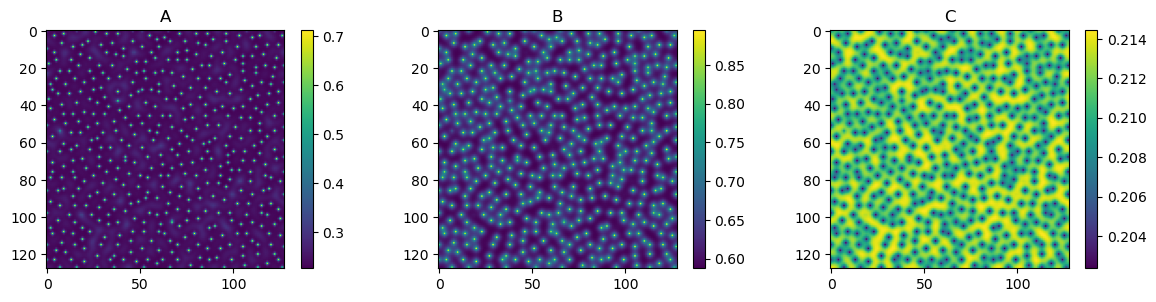

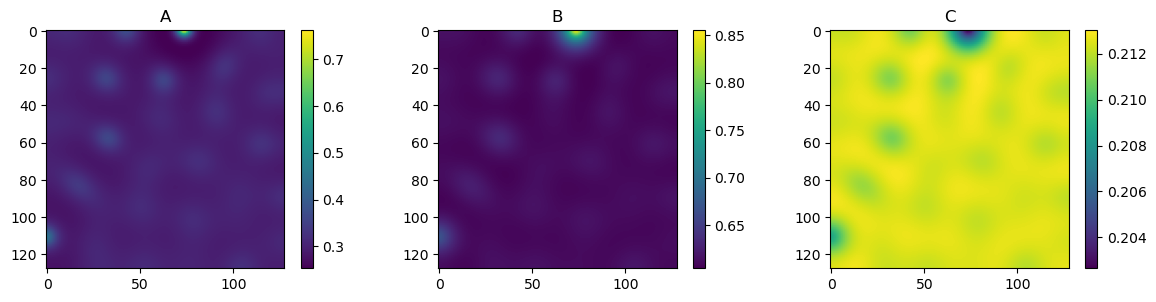

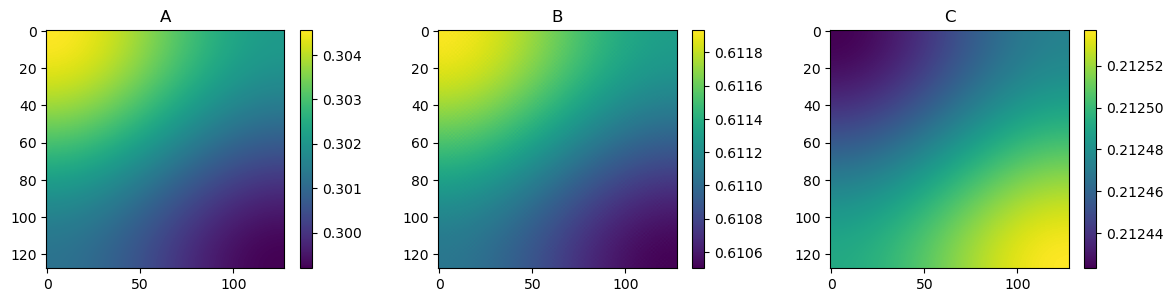

In [47]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [48]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

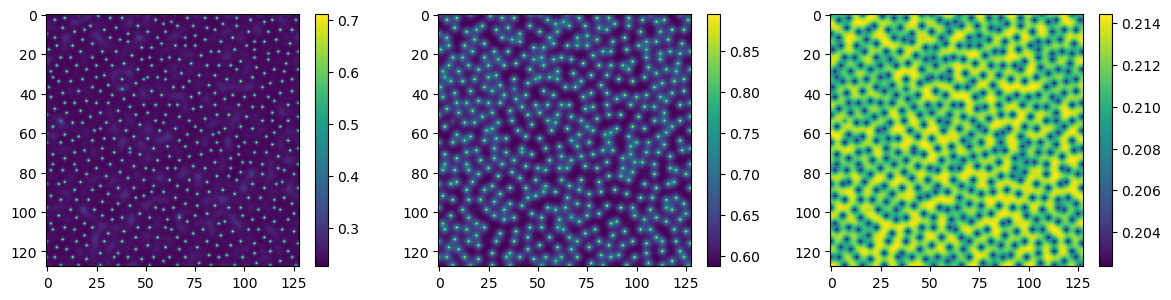

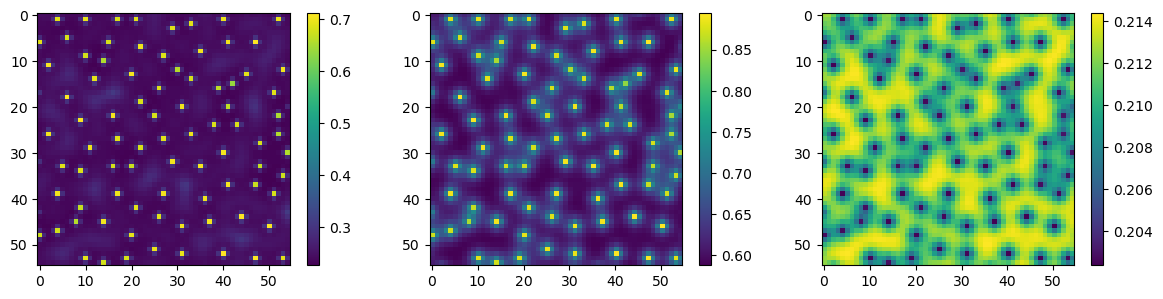

In [49]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [50]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [60]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 256, 256, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
#         if globals()["index"]%1000==0:
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                 ["C", "VC C"],          
#                 figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A), to(B), to(C)],
#                ["A", "B", "C"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(act(A, K_AA, n)*inh(B, K_BA, n)), to(act(A, K_AB, n)*inh(C, K_CB, n)), to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                ["VA", "VB", "VC"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(f_A), to(f_B), to(f_C)],
#                [f"fA {l2_res_A}", f"fB {l2_res_B}", f"fC {l2_res_C:.2f}"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(-b_C+ mu_C * C)],
#                [f"", f""],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A_rhs),  to(act_A_rhs)],
#               ["RHS A", "Actual RHS A"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(B_rhs),  to(act_B_rhs)],
#                   ["RHS B", "Actual RHS B"],          
#                   figsize=(12, 3)); plt.tight_layout()
#             plt.show()
#         globals()["index"]+=1
        grads = tape.gradient(l2, trainables)
#         if globals()["index"]%100==0:
#             print("="*10)
#             print("="*10)
#             print(grads[-2:])
#             print("="*10)
#             print("="*10)
#         globals()["index"]+=1
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [75]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=4e-3,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 1, False),
V_A_val=tf_param("V_A", 1, False),V_B_val=tf_param("V_B", 1, False),
                                  V_C_val=tf_param("V_C", 1, False),
K_AA_val=tf_param("K_AA", 1, False),K_AB_val=tf_param("K_AB", 1, False),
K_AC_val=tf_param("K_AC", 1, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 1, False),
K_CC_val=tf_param("K_CC", 1, False),                                  
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=1, w5=1
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
V_A: 1
V_B: 1
V_C: 1
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
K_AA: 1
K_AB: 1
K_AC: 1
K_BA: 1
K_BC: 1
K_CB: 1
K_CC: 1
n: 4.0


In [76]:
epochs=100000+1
params_est = np.zeros((epochs, 9))

# def epoch_callback1(epoch, loss_samples, index):
#     params_est[epoch, : ] = (b_A.numpy(), b_B.numpy(), b_C.numpy(), 
#                              V_A.numpy(), V_B.numpy(), V_C.numpy(),
#                              mu_A.numpy(), mu_B.numpy(), mu_C.numpy()
#                             )

In [77]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 5007.7687529325485
l2_res_A: 2153.69067383, l2_res_B: 1329.40063477, l2_res_C: 8.26740551, l2_res_A_rhs: 0.96741188, l2_res_B_rhs: 1515.44262695
b_A:0: 0.9959999322891235, b_B:0: 0.9959999322891235, b_C:0: 1.0040000677108765, V_A:0: 0.9959999322891235, V_B:0: 0.9959999322891235, V_C:0: 1.0040000677108765, K_AA:0: 1.0040000677108765, K_AB:0: 1.0040000677108765, K_AC:0: 1.0039987564086914, K_BA:0: 0.9959999322891235, K_BC:0: 1.0040000677108765, K_CB:0: 0.9959999322891235, K_CC:0: 0.9959999322891235
Time taken: 7.84s

Start of epoch 500
at epoch 500, total loss: 1268.8739821424242
l2_res_A: 7.38427782, l2_res_B: 114.46023560, l2_res_C: 0.00005979, l2_res_A_rhs: 5.81432104, l2_res_B_rhs: 1141.21508789
b_A:0: 0.18236373364925385, b_B:0: 0.2910497188568115, b_C:0: 1.0043312311172485, V_A:0: 0.6740962266921997, V_B:0: 1.4208945035934448, V_C:0: 1.4605398178100586, K_AA:0: 1.282967209815979, K_AB:0: 0.5953596234321594, K_AC:0: 0.7546084523200989, K_BA:


Start of epoch 7500
at epoch 7500, total loss: 673.2628645431719
l2_res_A: 0.11811266, l2_res_B: 187.65441895, l2_res_C: 0.00000725, l2_res_A_rhs: 0.38207984, l2_res_B_rhs: 485.10824585
b_A:0: 0.09075577557086945, b_B:0: 0.12674304842948914, b_C:0: 1.0023058652877808, V_A:0: 0.463083416223526, V_B:0: 4.155301570892334, V_C:0: 1.4409725666046143, K_AA:0: 0.4707464575767517, K_AB:0: 0.5834082961082458, K_AC:0: 0.8796223998069763, K_BA:0: 1.2804895639419556, K_BC:0: 0.4487638473510742, K_CB:0: 1.1559921503067017, K_CC:0: 0.30671706795692444
Time taken: 15.55s

Start of epoch 8000
at epoch 8000, total loss: 627.7398813196942
l2_res_A: 0.11392207, l2_res_B: 176.29731750, l2_res_C: 0.00000512, l2_res_A_rhs: 0.35182998, l2_res_B_rhs: 450.97680664
b_A:0: 0.0907825157046318, b_B:0: 0.13480336964130402, b_C:0: 1.002230167388916, V_A:0: 0.4510531425476074, V_B:0: 4.3127546310424805, V_C:0: 1.4403098821640015, K_AA:0: 0.4693262279033661, K_AB:0: 0.5947052240371704, K_AC:0: 0.8840283751487732, K_B


Start of epoch 15000
at epoch 15000, total loss: 542.5067024101836
l2_res_A: 0.09868597, l2_res_B: 170.07858276, l2_res_C: 0.00000768, l2_res_A_rhs: 0.30824679, l2_res_B_rhs: 372.02117920
b_A:0: 0.09333562105894089, b_B:0: 0.13061405718326569, b_C:0: 1.001273512840271, V_A:0: 0.3926542401313782, V_B:0: 5.900873184204102, V_C:0: 1.4354212284088135, K_AA:0: 0.4660555124282837, K_AB:0: 0.680877149105072, K_AC:0: 0.9341884255409241, K_BA:0: 1.9715445041656494, K_BC:0: 0.4651215374469757, K_CB:0: 2.0234358310699463, K_CC:0: 0.3150581419467926
Time taken: 15.93s

Start of epoch 15500
at epoch 15500, total loss: 505.9782912255981
l2_res_A: 0.10603689, l2_res_B: 162.04769897, l2_res_C: 0.00000086, l2_res_A_rhs: 0.27481085, l2_res_B_rhs: 343.54974365
b_A:0: 0.09132283180952072, b_B:0: 0.15459860861301422, b_C:0: 1.0011879205703735, V_A:0: 0.40172597765922546, V_B:0: 5.973124027252197, V_C:0: 1.4353885650634766, K_AA:0: 0.46184539794921875, K_AB:0: 0.68833327293396, K_AC:0: 0.936945915222168, K


Start of epoch 22500
at epoch 22500, total loss: 541.6979151816886
l2_res_A: 0.12203562, l2_res_B: 205.65325928, l2_res_C: 0.00000016, l2_res_A_rhs: 0.27637988, l2_res_B_rhs: 335.64624023
b_A:0: 0.09293467551469803, b_B:0: 0.12451887875795364, b_C:0: 1.0006790161132812, V_A:0: 0.40323004126548767, V_B:0: 6.828290939331055, V_C:0: 1.437410593032837, K_AA:0: 0.4688994586467743, K_AB:0: 0.7001532912254333, K_AC:0: 0.9646288156509399, K_BA:0: 2.128263473510742, K_BC:0: 0.47301286458969116, K_CB:0: 2.7806432247161865, K_CC:0: 0.3191905915737152
Time taken: 15.98s

Start of epoch 23000
at epoch 23000, total loss: 426.352615886135
l2_res_A: 0.09189046, l2_res_B: 144.53065491, l2_res_C: 0.00174561, l2_res_A_rhs: 0.24050142, l2_res_B_rhs: 281.48782349
b_A:0: 0.0915534496307373, b_B:0: 0.14075157046318054, b_C:0: 1.0005847215652466, V_A:0: 0.40896570682525635, V_B:0: 6.883209705352783, V_C:0: 1.4372597932815552, K_AA:0: 0.4660564661026001, K_AB:0: 0.7046336531639099, K_AC:0: 0.9653857350349426,


Start of epoch 30000
at epoch 30000, total loss: 438.8892704738538
l2_res_A: 0.11123866, l2_res_B: 163.85885620, l2_res_C: 0.00000072, l2_res_A_rhs: 0.23384164, l2_res_B_rhs: 274.68533325
b_A:0: 0.09163621068000793, b_B:0: 0.12912723422050476, b_C:0: 1.0004609823226929, V_A:0: 0.41184282302856445, V_B:0: 7.770139694213867, V_C:0: 1.44290292263031, K_AA:0: 0.4678580164909363, K_AB:0: 0.7241743803024292, K_AC:0: 0.9778376221656799, K_BA:0: 2.1733579635620117, K_BC:0: 0.4761783480644226, K_CB:0: 3.603337049484253, K_CC:0: 0.3210722804069519
Time taken: 16.52s

Start of epoch 30500
at epoch 30500, total loss: 339.6965249489658
l2_res_A: 0.08754827, l2_res_B: 123.13945007, l2_res_C: 0.00006296, l2_res_A_rhs: 0.19485122, l2_res_B_rhs: 216.27461243
b_A:0: 0.09083421528339386, b_B:0: 0.14197871088981628, b_C:0: 1.000388503074646, V_A:0: 0.41616547107696533, V_B:0: 7.810810089111328, V_C:0: 1.4432857036590576, K_AA:0: 0.46578824520111084, K_AB:0: 0.7294948697090149, K_AC:0: 0.9752373099327087,


Start of epoch 37500
at epoch 37500, total loss: 341.6100182237068
l2_res_A: 0.09417637, l2_res_B: 143.45355225, l2_res_C: 0.00000013, l2_res_A_rhs: 0.19287419, l2_res_B_rhs: 197.86941528
b_A:0: 0.09237132221460342, b_B:0: 0.09967618435621262, b_C:0: 1.000365972518921, V_A:0: 0.41895702481269836, V_B:0: 8.430617332458496, V_C:0: 1.449857473373413, K_AA:0: 0.4733416736125946, K_AB:0: 0.7173685431480408, K_AC:0: 0.9827758073806763, K_BA:0: 2.1462719440460205, K_BC:0: 0.4774250388145447, K_CB:0: 4.281470775604248, K_CC:0: 0.32215192914009094
Time taken: 15.60s

Start of epoch 38000
at epoch 38000, total loss: 314.615585568381
l2_res_A: 0.07899186, l2_res_B: 118.61997986, l2_res_C: 0.00002377, l2_res_A_rhs: 0.19069897, l2_res_B_rhs: 195.72589111
b_A:0: 0.0921526551246643, b_B:0: 0.12959496676921844, b_C:0: 1.0003341436386108, V_A:0: 0.41648411750793457, V_B:0: 8.443967819213867, V_C:0: 1.4502984285354614, K_AA:0: 0.47084006667137146, K_AB:0: 0.7416144609451294, K_AC:0: 0.9794648885726929,


Start of epoch 45000
at epoch 45000, total loss: 377.38761593932577
l2_res_A: 0.09605726, l2_res_B: 157.34977722, l2_res_C: 0.00003037, l2_res_A_rhs: 0.20867309, l2_res_B_rhs: 219.73307800
b_A:0: 0.09317080676555634, b_B:0: 0.12536562979221344, b_C:0: 1.000360131263733, V_A:0: 0.4130782186985016, V_B:0: 9.096460342407227, V_C:0: 1.4572805166244507, K_AA:0: 0.47473371028900146, K_AB:0: 0.7600337266921997, K_AC:0: 0.9809594750404358, K_BA:0: 2.1439359188079834, K_BC:0: 0.4779990613460541, K_CB:0: 4.953341484069824, K_CC:0: 0.3229915201663971
Time taken: 14.99s

Start of epoch 45500
at epoch 45500, total loss: 278.25595523820556
l2_res_A: 0.07926682, l2_res_B: 114.42384338, l2_res_C: 0.00000016, l2_res_A_rhs: 0.16471010, l2_res_B_rhs: 163.58813477
b_A:0: 0.09095144271850586, b_B:0: 0.12956416606903076, b_C:0: 1.00033438205719, V_A:0: 0.42999938130378723, V_B:0: 9.156826972961426, V_C:0: 1.457751989364624, K_AA:0: 0.4720032215118408, K_AB:0: 0.7467229962348938, K_AC:0: 0.9846442341804504,


Start of epoch 52500
at epoch 52500, total loss: 243.29901212570257
l2_res_A: 0.07185427, l2_res_B: 103.71053314, l2_res_C: 0.00052979, l2_res_A_rhs: 0.15803218, l2_res_B_rhs: 139.35806274
b_A:0: 0.09161408990621567, b_B:0: 0.12000291049480438, b_C:0: 1.0001916885375977, V_A:0: 0.43632882833480835, V_B:0: 9.83298110961914, V_C:0: 1.4646838903427124, K_AA:0: 0.4753100275993347, K_AB:0: 0.7513657808303833, K_AC:0: 0.9816770553588867, K_BA:0: 2.144038200378418, K_BC:0: 0.47810181975364685, K_CB:0: 5.653662204742432, K_CC:0: 0.32377466559410095
Time taken: 15.51s

Start of epoch 53000
at epoch 53000, total loss: 187.76349012820992
l2_res_A: 0.05115325, l2_res_B: 73.10337067, l2_res_C: 0.00000016, l2_res_A_rhs: 0.14399260, l2_res_B_rhs: 114.46497345
b_A:0: 0.0926176980137825, b_B:0: 0.12052630633115768, b_C:0: 1.0003201961517334, V_A:0: 0.4280308485031128, V_B:0: 9.856097221374512, V_C:0: 1.465391993522644, K_AA:0: 0.47788581252098083, K_AB:0: 0.762730062007904, K_AC:0: 0.9853748679161072,


Start of epoch 60000
at epoch 60000, total loss: 189.21156205015288
l2_res_A: 0.05515844, l2_res_B: 74.64384460, l2_res_C: 0.00000015, l2_res_A_rhs: 0.13722315, l2_res_B_rhs: 114.37533569
b_A:0: 0.09250293672084808, b_B:0: 0.1314956098794937, b_C:0: 1.000313639640808, V_A:0: 0.42878562211990356, V_B:0: 10.505765914916992, V_C:0: 1.4725329875946045, K_AA:0: 0.47546833753585815, K_AB:0: 0.7816604375839233, K_AC:0: 0.9857358932495117, K_BA:0: 2.269362211227417, K_BC:0: 0.4784303307533264, K_CB:0: 6.282628059387207, K_CC:0: 0.3241541087627411
Time taken: 16.44s

Start of epoch 60500
at epoch 60500, total loss: 291.33841357403423
l2_res_A: 0.07589708, l2_res_B: 133.13568115, l2_res_C: 0.00000133, l2_res_A_rhs: 0.17572317, l2_res_B_rhs: 157.95111084
b_A:0: 0.09280131757259369, b_B:0: 0.11118096113204956, b_C:0: 1.0003033876419067, V_A:0: 0.4274710416793823, V_B:0: 10.551630020141602, V_C:0: 1.473064661026001, K_AA:0: 0.47738727927207947, K_AB:0: 0.7719996571540833, K_AC:0: 0.984341442584991


Start of epoch 67500
at epoch 67500, total loss: 166.18697845269463
l2_res_A: 0.05476841, l2_res_B: 72.04734039, l2_res_C: 0.00000016, l2_res_A_rhs: 0.13076793, l2_res_B_rhs: 93.95410156
b_A:0: 0.0926012322306633, b_B:0: 0.1288585662841797, b_C:0: 1.0003082752227783, V_A:0: 0.43056029081344604, V_B:0: 11.23974609375, V_C:0: 1.4802340269088745, K_AA:0: 0.47456926107406616, K_AB:0: 0.7910362482070923, K_AC:0: 0.9858295917510986, K_BA:0: 2.5487637519836426, K_BC:0: 0.47860458493232727, K_CB:0: 6.955172061920166, K_CC:0: 0.3247537314891815
Time taken: 16.00s

Start of epoch 68000
at epoch 68000, total loss: 163.41251179613047
l2_res_A: 0.05197064, l2_res_B: 71.93226624, l2_res_C: 0.00000016, l2_res_A_rhs: 0.13290276, l2_res_B_rhs: 91.29537201
b_A:0: 0.09241092205047607, b_B:0: 0.12491074204444885, b_C:0: 1.0003085136413574, V_A:0: 0.4271956980228424, V_B:0: 11.290972709655762, V_C:0: 1.4807602167129517, K_AA:0: 0.4748800992965698, K_AB:0: 0.7913163900375366, K_AC:0: 0.9860473275184631, K_


Start of epoch 75000
at epoch 75000, total loss: 149.83529145233575
l2_res_A: 0.05037861, l2_res_B: 62.83719635, l2_res_C: 0.00000016, l2_res_A_rhs: 0.12062130, l2_res_B_rhs: 86.82709503
b_A:0: 0.0909218043088913, b_B:0: 0.14709104597568512, b_C:0: 1.0003076791763306, V_A:0: 0.4285668730735779, V_B:0: 11.89802074432373, V_C:0: 1.4878934621810913, K_AA:0: 0.47115272283554077, K_AB:0: 0.820167601108551, K_AC:0: 0.9860960841178894, K_BA:0: 2.835033893585205, K_BC:0: 0.4787341058254242, K_CB:0: 7.541141986846924, K_CC:0: 0.32531803846359253
Time taken: 16.79s

Start of epoch 75500
at epoch 75500, total loss: 162.2208119283314
l2_res_A: 0.04990312, l2_res_B: 68.52462006, l2_res_C: 0.00084293, l2_res_A_rhs: 0.12771511, l2_res_B_rhs: 93.51773071
b_A:0: 0.09187258780002594, b_B:0: 0.12388832867145538, b_C:0: 1.0007390975952148, V_A:0: 0.42853155732154846, V_B:0: 11.956188201904297, V_C:0: 1.4885698556900024, K_AA:0: 0.4753648340702057, K_AB:0: 0.8035183548927307, K_AC:0: 0.9850278496742249, K


Start of epoch 82500
at epoch 82500, total loss: 181.88819572574812
l2_res_A: 0.05438363, l2_res_B: 79.76770020, l2_res_C: 0.00000642, l2_res_A_rhs: 0.14086592, l2_res_B_rhs: 101.92523956
b_A:0: 0.0913257747888565, b_B:0: 0.1592470109462738, b_C:0: 1.0002774000167847, V_A:0: 0.4221271574497223, V_B:0: 12.445423126220703, V_C:0: 1.4956586360931396, K_AA:0: 0.4691601097583771, K_AB:0: 0.8431277275085449, K_AC:0: 0.9845561981201172, K_BA:0: 2.8940534591674805, K_BC:0: 0.47892236709594727, K_CB:0: 8.034369468688965, K_CC:0: 0.3259643018245697
Time taken: 15.12s

Start of epoch 83000
at epoch 83000, total loss: 213.57893694491514
l2_res_A: 0.06457622, l2_res_B: 97.12850189, l2_res_C: 0.00000016, l2_res_A_rhs: 0.15270437, l2_res_B_rhs: 116.23315430
b_A:0: 0.09208417683839798, b_B:0: 0.13092079758644104, b_C:0: 1.0003023147583008, V_A:0: 0.426239013671875, V_B:0: 12.502690315246582, V_C:0: 1.4961378574371338, K_AA:0: 0.47416165471076965, K_AB:0: 0.8211514949798584, K_AC:0: 0.9863022565841675


Start of epoch 90000
at epoch 90000, total loss: 147.8157508645454
l2_res_A: 0.04575080, l2_res_B: 66.55867004, l2_res_C: 0.00007476, l2_res_A_rhs: 0.12856026, l2_res_B_rhs: 81.08269501
b_A:0: 0.09195562452077866, b_B:0: 0.13438111543655396, b_C:0: 1.0001558065414429, V_A:0: 0.4245133101940155, V_B:0: 12.951017379760742, V_C:0: 1.5032750368118286, K_AA:0: 0.47339949011802673, K_AB:0: 0.8321030735969543, K_AC:0: 0.9827659130096436, K_BA:0: 3.3884432315826416, K_BC:0: 0.47898730635643005, K_CB:0: 8.467120170593262, K_CC:0: 0.32661697268486023
Time taken: 16.54s

Start of epoch 90500
at epoch 90500, total loss: 226.4107048784552
l2_res_A: 0.06603154, l2_res_B: 97.72200012, l2_res_C: 0.00000076, l2_res_A_rhs: 0.14939059, l2_res_B_rhs: 128.47328186
b_A:0: 0.09250692278146744, b_B:0: 0.12700223922729492, b_C:0: 1.000292181968689, V_A:0: 0.42416325211524963, V_B:0: 12.98091983795166, V_C:0: 1.5038262605667114, K_AA:0: 0.4748496413230896, K_AB:0: 0.8304080963134766, K_AC:0: 0.9863870739936829


Start of epoch 97500
at epoch 97500, total loss: 150.74604908193487
l2_res_A: 0.04834974, l2_res_B: 63.88864136, l2_res_C: 0.00000096, l2_res_A_rhs: 0.12759951, l2_res_B_rhs: 86.68145752
b_A:0: 0.09179560840129852, b_B:0: 0.1319323033094406, b_C:0: 1.0003290176391602, V_A:0: 0.42538338899612427, V_B:0: 13.37165641784668, V_C:0: 1.511130452156067, K_AA:0: 0.47361186146736145, K_AB:0: 0.8377227187156677, K_AC:0: 0.9841305017471313, K_BA:0: 3.7300608158111572, K_BC:0: 0.47925353050231934, K_CB:0: 8.822776794433594, K_CC:0: 0.32709792256355286
Time taken: 15.47s

Start of epoch 98000
at epoch 98000, total loss: 125.89170089277576
l2_res_A: 0.03980229, l2_res_B: 55.73269653, l2_res_C: 0.00000016, l2_res_A_rhs: 0.12408473, l2_res_B_rhs: 69.99511719
b_A:0: 0.09166736155748367, b_B:0: 0.14454901218414307, b_C:0: 1.0002954006195068, V_A:0: 0.4269249439239502, V_B:0: 13.396098136901855, V_C:0: 1.5116215944290161, K_AA:0: 0.4734658896923065, K_AB:0: 0.8462979793548584, K_AC:0: 0.986691415309906,

In [82]:
optimizer1.lr.assign(2e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.002>

In [ ]:
losses2 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 155.71408686691393
l2_res_A: 0.04914722, l2_res_B: 70.55417633, l2_res_C: 0.00001450, l2_res_A_rhs: 0.12886862, l2_res_B_rhs: 84.98188019
b_A:0: 0.09215123951435089, b_B:0: 0.12873274087905884, b_C:0: 1.000285267829895, V_A:0: 0.42833617329597473, V_B:0: 13.543163299560547, V_C:0: 1.5137783288955688, K_AA:0: 0.4752369225025177, K_AB:0: 0.837749183177948, K_AC:0: 0.9836796522140503, K_BA:0: 3.8697361946105957, K_BC:0: 0.47933635115623474, K_CB:0: 8.962783813476562, K_CC:0: 0.3273114860057831
Time taken: 0.11s

Start of epoch 500
at epoch 500, total loss: 75.29637484829544
l2_res_A: 0.02918777, l2_res_B: 34.37883377, l2_res_C: 0.00000015, l2_res_A_rhs: 0.10194950, l2_res_B_rhs: 40.78640366
b_A:0: 0.09201890230178833, b_B:0: 0.12272598594427109, b_C:0: 1.0002976655960083, V_A:0: 0.43365785479545593, V_B:0: 13.579482078552246, V_C:0: 1.513871431350708, K_AA:0: 0.4771076440811157, K_AB:0: 0.8282712697982788, K_AC:0: 0.9865798950195312, K_BA:0: 3.890


Start of epoch 7500
at epoch 7500, total loss: 88.55149138565085
l2_res_A: 0.03240776, l2_res_B: 40.41173553, l2_res_C: 0.00000011, l2_res_A_rhs: 0.10499050, l2_res_B_rhs: 48.00235748
b_A:0: 0.09208124130964279, b_B:0: 0.12622182071208954, b_C:0: 1.0003899335861206, V_A:0: 0.43272554874420166, V_B:0: 14.184732437133789, V_C:0: 1.5162179470062256, K_AA:0: 0.4768792688846588, K_AB:0: 0.8426786661148071, K_AC:0: 0.9812309741973877, K_BA:0: 4.190986156463623, K_BC:0: 0.47804275155067444, K_CB:0: 9.45161247253418, K_CC:0: 0.3268488645553589
Time taken: 15.74s

Start of epoch 8000
at epoch 8000, total loss: 98.81593897307357
l2_res_A: 0.03548026, l2_res_B: 44.80757904, l2_res_C: 0.00000025, l2_res_A_rhs: 0.11001016, l2_res_B_rhs: 53.86286926
b_A:0: 0.09229052066802979, b_B:0: 0.1243901327252388, b_C:0: 1.000476360321045, V_A:0: 0.4303872585296631, V_B:0: 14.226593971252441, V_C:0: 1.5164192914962769, K_AA:0: 0.47692590951919556, K_AB:0: 0.8466211557388306, K_AC:0: 0.9804392457008362, K_BA:0


Start of epoch 15000
at epoch 15000, total loss: 86.56052757382713
l2_res_A: 0.03185438, l2_res_B: 38.76516342, l2_res_C: 0.00000831, l2_res_A_rhs: 0.10701877, l2_res_B_rhs: 47.65648270
b_A:0: 0.09213168919086456, b_B:0: 0.12847980856895447, b_C:0: 1.0003910064697266, V_A:0: 0.4323435127735138, V_B:0: 14.828473091125488, V_C:0: 1.5184435844421387, K_AA:0: 0.47671300172805786, K_AB:0: 0.8566215634346008, K_AC:0: 0.9792158603668213, K_BA:0: 4.628876686096191, K_BC:0: 0.4775889813899994, K_CB:0: 9.926994323730469, K_CC:0: 0.32682886719703674
Time taken: 15.48s

Start of epoch 15500
at epoch 15500, total loss: 99.91494658840514
l2_res_A: 0.03586007, l2_res_B: 47.23009872, l2_res_C: 0.00000058, l2_res_A_rhs: 0.10860865, l2_res_B_rhs: 52.54037857
b_A:0: 0.09206586331129074, b_B:0: 0.12521815299987793, b_C:0: 1.0004173517227173, V_A:0: 0.4312777817249298, V_B:0: 14.86897087097168, V_C:0: 1.5186117887496948, K_AA:0: 0.477398157119751, K_AB:0: 0.8566396236419678, K_AC:0: 0.9791710376739502, K_


Start of epoch 22500
at epoch 22500, total loss: 79.00757012974645
l2_res_A: 0.02973623, l2_res_B: 36.57511902, l2_res_C: 0.00016243, l2_res_A_rhs: 0.10304150, l2_res_B_rhs: 42.29951096
b_A:0: 0.09245727956295013, b_B:0: 0.12620297074317932, b_C:0: 1.0003300905227661, V_A:0: 0.43054696917533875, V_B:0: 15.39869213104248, V_C:0: 1.5204002857208252, K_AA:0: 0.4774387776851654, K_AB:0: 0.8679232001304626, K_AC:0: 0.9780991077423096, K_BA:0: 5.108127117156982, K_BC:0: 0.47736260294914246, K_CB:0: 10.335633277893066, K_CC:0: 0.32703205943107605
Time taken: 15.71s

Start of epoch 23000
at epoch 23000, total loss: 70.21665614919038
l2_res_A: 0.02773771, l2_res_B: 32.79835129, l2_res_C: 0.00028030, l2_res_A_rhs: 0.10026304, l2_res_B_rhs: 37.29002380
b_A:0: 0.09187576919794083, b_B:0: 0.1309933364391327, b_C:0: 1.0003528594970703, V_A:0: 0.4330686330795288, V_B:0: 15.434267044067383, V_C:0: 1.5205469131469727, K_AA:0: 0.4770447015762329, K_AB:0: 0.8676802515983582, K_AC:0: 0.9783348441123962, 


Start of epoch 30000
at epoch 30000, total loss: 87.31409010960772
l2_res_A: 0.03269650, l2_res_B: 40.42172241, l2_res_C: 0.00000009, l2_res_A_rhs: 0.10610054, l2_res_B_rhs: 46.75357056
b_A:0: 0.09189493954181671, b_B:0: 0.13194550573825836, b_C:0: 1.000438928604126, V_A:0: 0.43260514736175537, V_B:0: 15.891615867614746, V_C:0: 1.522565484046936, K_AA:0: 0.47681137919425964, K_AB:0: 0.8792550563812256, K_AC:0: 0.9783514142036438, K_BA:0: 5.607032299041748, K_BC:0: 0.4774831235408783, K_CB:0: 10.676762580871582, K_CC:0: 0.32699504494667053
Time taken: 15.02s

Start of epoch 30500
at epoch 30500, total loss: 61.652959909152116
l2_res_A: 0.02534774, l2_res_B: 27.79604530, l2_res_C: 0.00000009, l2_res_A_rhs: 0.09811112, l2_res_B_rhs: 33.73345566
b_A:0: 0.09188126027584076, b_B:0: 0.13236311078071594, b_C:0: 1.0004388093948364, V_A:0: 0.43317049741744995, V_B:0: 15.924555778503418, V_C:0: 1.5226972103118896, K_AA:0: 0.4765816032886505, K_AB:0: 0.8779226541519165, K_AC:0: 0.9783808588981628


Start of epoch 37500
at epoch 37500, total loss: 81.82777998623351
l2_res_A: 0.03094860, l2_res_B: 37.89353943, l2_res_C: 0.00002805, l2_res_A_rhs: 0.10576330, l2_res_B_rhs: 43.79750061
b_A:0: 0.09213928878307343, b_B:0: 0.13017013669013977, b_C:0: 1.0004156827926636, V_A:0: 0.4307224750518799, V_B:0: 16.341739654541016, V_C:0: 1.5245463848114014, K_AA:0: 0.476995050907135, K_AB:0: 0.885617733001709, K_AC:0: 0.9773058891296387, K_BA:0: 6.129555702209473, K_BC:0: 0.47750046849250793, K_CB:0: 10.974675178527832, K_CC:0: 0.3271518647670746
Time taken: 15.11s

Start of epoch 38000
at epoch 38000, total loss: 62.50341305608126
l2_res_A: 0.02566605, l2_res_B: 28.65950775, l2_res_C: 0.00000010, l2_res_A_rhs: 0.09847827, l2_res_B_rhs: 33.71976089
b_A:0: 0.09190093725919724, b_B:0: 0.1310865879058838, b_C:0: 1.0004384517669678, V_A:0: 0.43310827016830444, V_B:0: 16.373016357421875, V_C:0: 1.524679183959961, K_AA:0: 0.47683754563331604, K_AB:0: 0.8831397891044617, K_AC:0: 0.9783270955085754, K_


Start of epoch 45000
at epoch 45000, total loss: 90.51951110273512
l2_res_A: 0.03361231, l2_res_B: 43.10063934, l2_res_C: 0.00000863, l2_res_A_rhs: 0.10819699, l2_res_B_rhs: 47.27705383
b_A:0: 0.09195489436388016, b_B:0: 0.1293012946844101, b_C:0: 1.0004163980484009, V_A:0: 0.4314064681529999, V_B:0: 16.763063430786133, V_C:0: 1.526491403579712, K_AA:0: 0.4771031439304352, K_AB:0: 0.8920217752456665, K_AC:0: 0.9777587056159973, K_BA:0: 6.665314197540283, K_BC:0: 0.4775044620037079, K_CB:0: 11.246213912963867, K_CC:0: 0.32731378078460693
Time taken: 15.89s

Start of epoch 45500
at epoch 45500, total loss: 67.8012849450866
l2_res_A: 0.02707209, l2_res_B: 30.58453369, l2_res_C: 0.00000009, l2_res_A_rhs: 0.10024349, l2_res_B_rhs: 37.08943558
b_A:0: 0.09184738248586655, b_B:0: 0.13262556493282318, b_C:0: 1.0004395246505737, V_A:0: 0.43411847949028015, V_B:0: 16.79132843017578, V_C:0: 1.5266542434692383, K_AA:0: 0.4763329327106476, K_AB:0: 0.8908779621124268, K_AC:0: 0.9783438444137573, K_B


Start of epoch 52500
at epoch 52500, total loss: 62.0425040067521
l2_res_A: 0.02567956, l2_res_B: 28.55640984, l2_res_C: 0.00001026, l2_res_A_rhs: 0.09809966, l2_res_B_rhs: 33.36230469
b_A:0: 0.0917145386338234, b_B:0: 0.13408607244491577, b_C:0: 1.0004756450653076, V_A:0: 0.4342721998691559, V_B:0: 17.149333953857422, V_C:0: 1.5285212993621826, K_AA:0: 0.47629979252815247, K_AB:0: 0.898216187953949, K_AC:0: 0.9778005480766296, K_BA:0: 7.16314172744751, K_BC:0: 0.4775947630405426, K_CB:0: 11.490391731262207, K_CC:0: 0.32739803194999695
Time taken: 15.48s

Start of epoch 53000
at epoch 53000, total loss: 79.53935014018913
l2_res_A: 0.02957306, l2_res_B: 35.31507111, l2_res_C: 0.00000045, l2_res_A_rhs: 0.10407976, l2_res_B_rhs: 44.09062576
b_A:0: 0.092081218957901, b_B:0: 0.13039910793304443, b_C:0: 1.00044584274292, V_A:0: 0.431552529335022, V_B:0: 17.172685623168945, V_C:0: 1.5286225080490112, K_AA:0: 0.4765976667404175, K_AB:0: 0.9003432393074036, K_AC:0: 0.9783475399017334, K_BA:0: 


Start of epoch 60000
at epoch 60000, total loss: 62.024767519580536
l2_res_A: 0.02520675, l2_res_B: 28.45046806, l2_res_C: 0.00000009, l2_res_A_rhs: 0.09970220, l2_res_B_rhs: 33.44939041
b_A:0: 0.09210202097892761, b_B:0: 0.1320265680551529, b_C:0: 1.0004384517669678, V_A:0: 0.4313744902610779, V_B:0: 17.513277053833008, V_C:0: 1.5304583311080933, K_AA:0: 0.4767194986343384, K_AB:0: 0.9063287377357483, K_AC:0: 0.9783883094787598, K_BA:0: 7.69666862487793, K_BC:0: 0.4775923490524292, K_CB:0: 11.715692520141602, K_CC:0: 0.32755646109580994
Time taken: 15.24s

Start of epoch 60500
at epoch 60500, total loss: 68.49133897038622
l2_res_A: 0.02655163, l2_res_B: 30.53119278, l2_res_C: 0.00000009, l2_res_A_rhs: 0.10084224, l2_res_B_rhs: 37.83275223
b_A:0: 0.09219321608543396, b_B:0: 0.1309659630060196, b_C:0: 1.000437617301941, V_A:0: 0.4310885965824127, V_B:0: 17.53622055053711, V_C:0: 1.5305932760238647, K_AA:0: 0.4767979383468628, K_AB:0: 0.9073715806007385, K_AC:0: 0.978399395942688, K_BA:


Start of epoch 67500
at epoch 67500, total loss: 62.87514621993478
l2_res_A: 0.02568447, l2_res_B: 28.38623047, l2_res_C: 0.00000283, l2_res_A_rhs: 0.09930633, l2_res_B_rhs: 34.36392212
b_A:0: 0.0917009562253952, b_B:0: 0.13275980949401855, b_C:0: 1.000449299812317, V_A:0: 0.4341091513633728, V_B:0: 17.861621856689453, V_C:0: 1.532446026802063, K_AA:0: 0.47670191526412964, K_AB:0: 0.9105476140975952, K_AC:0: 0.9779980778694153, K_BA:0: 8.230264663696289, K_BC:0: 0.47764378786087036, K_CB:0: 11.92800235748291, K_CC:0: 0.32769715785980225
Time taken: 15.34s

Start of epoch 68000
at epoch 68000, total loss: 60.67444491640708
l2_res_A: 0.02466552, l2_res_B: 27.35398483, l2_res_C: 0.00002229, l2_res_A_rhs: 0.09843035, l2_res_B_rhs: 33.19734192
b_A:0: 0.09202533215284348, b_B:0: 0.13211622834205627, b_C:0: 1.0004942417144775, V_A:0: 0.432140976190567, V_B:0: 17.88300323486328, V_C:0: 1.5326098203659058, K_AA:0: 0.47697383165359497, K_AB:0: 0.911584198474884, K_AC:0: 0.978457510471344, K_BA:


Start of epoch 75000
at epoch 75000, total loss: 80.0738196893526
l2_res_A: 0.03027380, l2_res_B: 37.16571045, l2_res_C: 0.00001861, l2_res_A_rhs: 0.10449377, l2_res_B_rhs: 42.77332306
b_A:0: 0.09204093366861343, b_B:0: 0.13160143792629242, b_C:0: 1.0003973245620728, V_A:0: 0.4322337508201599, V_B:0: 18.19029998779297, V_C:0: 1.5343645811080933, K_AA:0: 0.47718656063079834, K_AB:0: 0.9183161854743958, K_AC:0: 0.9775399565696716, K_BA:0: 8.774130821228027, K_BC:0: 0.47762948274612427, K_CB:0: 12.122204780578613, K_CC:0: 0.327907919883728
Time taken: 15.38s

Start of epoch 75500
at epoch 75500, total loss: 58.831182408582436
l2_res_A: 0.02453142, l2_res_B: 26.40879631, l2_res_C: 0.00000013, l2_res_A_rhs: 0.09695886, l2_res_B_rhs: 32.30089569
b_A:0: 0.09184743463993073, b_B:0: 0.13455118238925934, b_C:0: 1.000439167022705, V_A:0: 0.43378394842147827, V_B:0: 18.212568283081055, V_C:0: 1.5345338582992554, K_AA:0: 0.4768217206001282, K_AB:0: 0.917881429195404, K_AC:0: 0.9784442782402039, K_


Start of epoch 82500
at epoch 82500, total loss: 78.33890226916719
l2_res_A: 0.02975151, l2_res_B: 36.10337448, l2_res_C: 0.00000674, l2_res_A_rhs: 0.10179234, l2_res_B_rhs: 42.10397720
b_A:0: 0.09200631827116013, b_B:0: 0.13131393492221832, b_C:0: 1.0004063844680786, V_A:0: 0.4329524636268616, V_B:0: 18.5091495513916, V_C:0: 1.5363355875015259, K_AA:0: 0.4773709177970886, K_AB:0: 0.9214536547660828, K_AC:0: 0.9784346222877502, K_BA:0: 9.280678749084473, K_BC:0: 0.4776599109172821, K_CB:0: 12.308526039123535, K_CC:0: 0.3280143439769745
Time taken: 15.23s

Start of epoch 83000
at epoch 83000, total loss: 65.54713813219624
l2_res_A: 0.02647871, l2_res_B: 30.51750755, l2_res_C: 0.00000009, l2_res_A_rhs: 0.10025489, l2_res_B_rhs: 34.90289688
b_A:0: 0.0920424610376358, b_B:0: 0.13192886114120483, b_C:0: 1.0004372596740723, V_A:0: 0.43248945474624634, V_B:0: 18.530128479003906, V_C:0: 1.5365102291107178, K_AA:0: 0.4773581624031067, K_AB:0: 0.9210701584815979, K_AC:0: 0.9784502983093262, K_B


Start of epoch 90000
at epoch 90000, total loss: 57.11942573608792
l2_res_A: 0.02441308, l2_res_B: 25.93546486, l2_res_C: 0.00000035, l2_res_A_rhs: 0.09697688, l2_res_B_rhs: 31.06257057
b_A:0: 0.09221690893173218, b_B:0: 0.13351383805274963, b_C:0: 1.0004298686981201, V_A:0: 0.43150460720062256, V_B:0: 18.808338165283203, V_C:0: 1.5383260250091553, K_AA:0: 0.47724828124046326, K_AB:0: 0.9292972087860107, K_AC:0: 0.9784899353981018, K_BA:0: 9.76703929901123, K_BC:0: 0.47771787643432617, K_CB:0: 12.481352806091309, K_CC:0: 0.32813215255737305
Time taken: 15.04s

Start of epoch 90500
at epoch 90500, total loss: 64.20145477956521
l2_res_A: 0.02619077, l2_res_B: 29.62337494, l2_res_C: 0.00000513, l2_res_A_rhs: 0.09949137, l2_res_B_rhs: 34.45239258
b_A:0: 0.09202422946691513, b_B:0: 0.13333174586296082, b_C:0: 1.0004265308380127, V_A:0: 0.43226009607315063, V_B:0: 18.82918930053711, V_C:0: 1.538467288017273, K_AA:0: 0.47722241282463074, K_AB:0: 0.9280992746353149, K_AC:0: 0.9779157042503357


Start of epoch 97500
at epoch 97500, total loss: 63.65001066080261
l2_res_A: 0.02629143, l2_res_B: 28.46286201, l2_res_C: 0.00000009, l2_res_A_rhs: 0.09723179, l2_res_B_rhs: 35.06362534
b_A:0: 0.09177514910697937, b_B:0: 0.1366054117679596, b_C:0: 1.0004348754882812, V_A:0: 0.43562155961990356, V_B:0: 19.106792449951172, V_C:0: 1.540315866470337, K_AA:0: 0.47706466913223267, K_AB:0: 0.9301382899284363, K_AC:0: 0.9785566329956055, K_BA:0: 10.258387565612793, K_BC:0: 0.47776511311531067, K_CB:0: 12.651226043701172, K_CC:0: 0.3282729387283325
Time taken: 15.57s

Start of epoch 98000
at epoch 98000, total loss: 60.44557872328106
l2_res_A: 0.02545548, l2_res_B: 27.61773491, l2_res_C: 0.00000009, l2_res_A_rhs: 0.09751611, l2_res_B_rhs: 32.70487213
b_A:0: 0.09198731929063797, b_B:0: 0.1347275674343109, b_C:0: 1.000435709953308, V_A:0: 0.43472328782081604, V_B:0: 19.127643585205078, V_C:0: 1.5404452085494995, K_AA:0: 0.47721680998802185, K_AB:0: 0.9291942715644836, K_AC:0: 0.9785541296005249,

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0
'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0,
'K_BA': 0.5, 'K_BC': 0.5,
'K_CB': 100.0, 'K_CC': 1.0       

In [54]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.1, 'mu_A': 0.5, 'V_A': 20.0, 'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 0.5, 'V_B': 25.0, 'K_BA': 0.5, 'K_BC': 0.5, 'b_C': 1.0, 'mu_C': 5.0, 'V_C': 100.0, 'K_CB': 100.0, 'K_CC': 1.0}


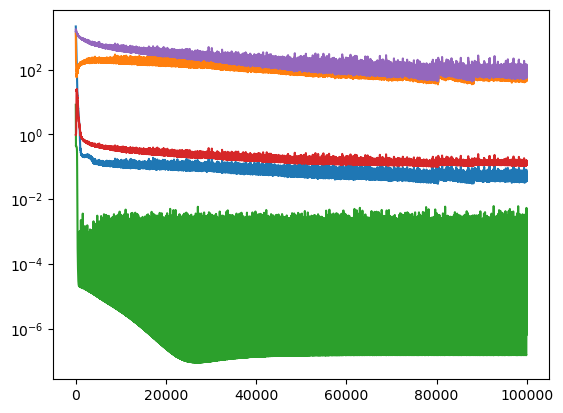

In [78]:
plt.plot(losses1)
plt.yscale('log')

In [79]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [80]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der-actual_A_der)**2))
    print(np.sum((B_der-actual_B_der)**2))


    plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der,  actual_A_der],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der,  actual_B_der],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.28151606347327573
334.02861238587695


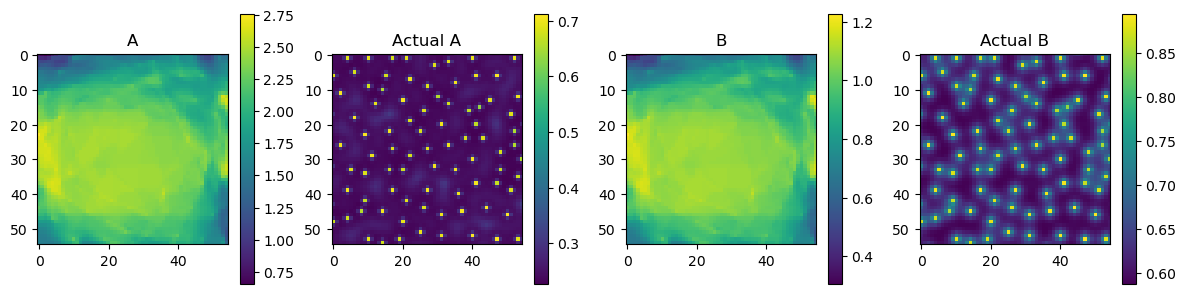

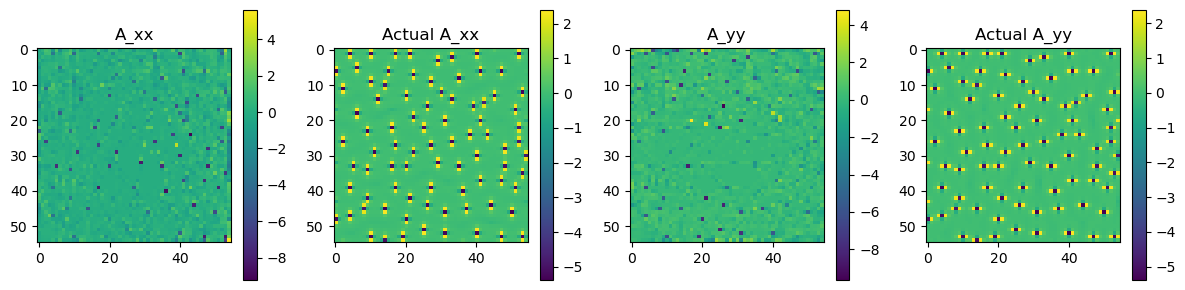

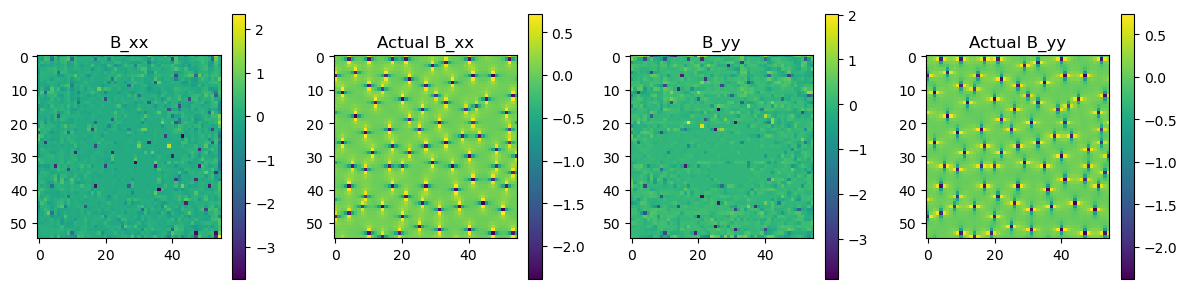

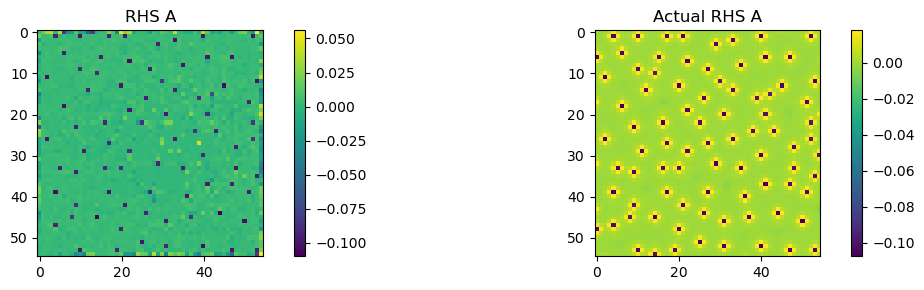

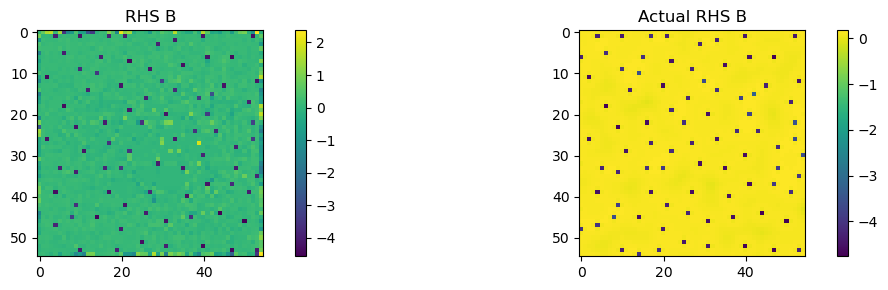

In [81]:
plot_state(pinn1)